# Machine Learning - Project 1: Patient Charges Regression

Description: [ML2021_HuyNguyen.pdf](https://drive.google.com/file/d/1dOgSEndQcD397t2v6a57SKbTSn5zV0VA/view?usp=sharing)

Dataset: [Medical Cost Personal Datasets](https://www.kaggle.com/mirichoi0218/insurance)

Direct-link to google colab: [Read Only](https://colab.research.google.com/drive/1n5eU-bE8Q_01yvMRXK6R7xuS3bYDZcs7)

Owner: group 11. 

## Import thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor,GradientBoostingRegressor, StackingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, PredefinedSplit

from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split



## Đọc dữ liệu

In [2]:
!wget -qO- https://drive.google.com/uc?id=19ig1GFDCioN_O2LjhF_JSzhwl_erengT > train.csv
!wget -qO- https://drive.google.com/uc?id=1xvHczHpMFgPIQhyMKWT__fHimq0yVVK9 > test.csv

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Khám phá dữ liệu tập train

### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [4]:
train_df.head()

,age,sex,bmi,children,smoker,region,charges
0,24,male,23.655,0,no,northwest,2352.96845
1,28,female,26.510,2,no,southeast,4340.44090
2,51,male,39.700,1,no,southwest,9391.34600
3,47,male,36.080,1,yes,southeast,42211.13820
4,46,female,28.900,2,no,southwest,8823.27900


In [5]:
train_df.shape

(1003, 7)

In [6]:
test_df.shape

(335, 7)

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Quan sát sơ bộ dữ liệu ta thấy mỗi dòng chứa thông tin của một người, và có vẻ không có vấn đề các dòng có ý nghĩa khác nhau.


### Dữ liệu có các dòng bị lặp không?

In [7]:
train_df.duplicated().sum()

0

Vậy bộ dữ liệu này không có dòng nào bị lặp.

### Mỗi cột có ý nghĩa gì?

- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: Smoking
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance

### Kiểu dữ liệu của các cột 

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1003 non-null   int64  
 1   sex       1003 non-null   object 
 2   bmi       1003 non-null   float64
 3   children  1003 non-null   int64  
 4   smoker    1003 non-null   object 
 5   region    1003 non-null   object 
 6   charges   1003 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 55.0+ KB


Ta thấy dữ liệu không có missing value. Các cột `sex`, `smoker`, `region` có kiểu categorical không có thứ tự nên ta sẽ dùng one-hot encoding để chuyển sang dạng số.

### Sự phân bố của dữ liệu

#### Với mỗi cột input có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?

In [9]:
train_df[['age', 'bmi', 'charges']].describe()[1:]

,age,bmi,charges
mean,39.255234,30.511780,13267.935817
std,14.039105,6.013107,12051.356547
min,18.000000,15.960000,1121.873900
25%,27.000000,26.210000,4780.839400
50%,39.000000,30.200000,9447.382400
75%,51.000000,34.430000,16840.667970
max,64.000000,53.130000,62592.873090


- Độ tuổi trung bình là 39.2 và lớn nhất là 64.
- Chỉ số BMI trung bình là 30.5  quá lớn (béo phì).
- Mean của `charges` lớn hơn median chứng tỏ phân phối của `charges` bị lệch sang phải.




#### Với mỗi cột input có kiểu dữ liệu không phải dạng số, các giá trị được phân bố như thế nào?

In [10]:
pd.set_option('display.max_colwidth', 200) # Để nhìn rõ hơn
df = train_df[['sex', 'children', 'smoker', 'region']]
def num_values(df):
    return df.nunique()
def value_ratios(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
df.agg([num_values, value_ratios])

,sex,children,smoker,region
num_values,2,6,2,4
value_ratios,"{'male': 50.4, 'female': 49.6}","{0: 42.4, 1: 24.5, 2: 17.8, 3: 12.0, 4: 2.1, 5: 1.2}","{'no': 79.5, 'yes': 20.5}","{'southeast': 25.8, 'northeast': 25.0, 'southwest': 24.6, 'northwest': 24.5}"


- Ta thấy cột `sex`, `region` dữ liệu phân bố đều, còn cột `smoker` có sự chênh lệch đáng kể.
- Cột `children` các giá trị phổ biến là 0, 1, 2, 3.

In [11]:
encoder = LabelEncoder()
data=train_df.copy()
data['smoker'] = encoder.fit_transform(data['smoker'])
data['region'] = encoder.fit_transform(data['region'])
data['sex'] = encoder.fit_transform(data['sex'])

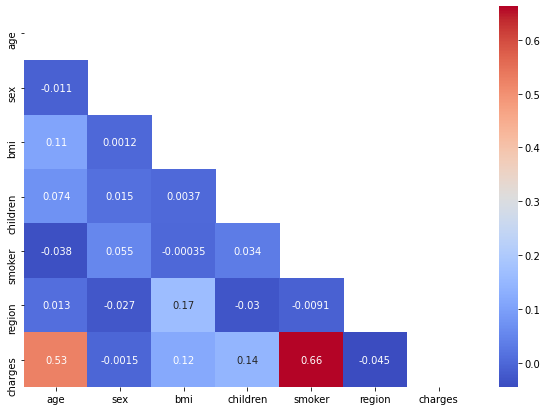

In [12]:
mask = np.triu(np.ones_like(data.corr('spearman')))
plt.subplots(figsize=(10,7))
dataplot = sns.heatmap(data.corr('spearman'), cmap="coolwarm", annot=True, mask=mask)

Từ biểu đồ trên, ta có thể dự đoán rằng 2 thuộc tính “age” và “smoker” có ảnh hưởng mạnh tới chi phí y tế cá nhân, là nguyên nhân chính tác động chi phí y tế phải trả của mỗi người. Còn 2 thuộc tính “sex” và “region” gần như không có tác động đến chi phí khám bệnh.

In [13]:
data.describe()

,age,sex,bmi,children,smoker,region,charges
count,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000
mean,39.255234,0.504487,30.511780,1.104686,0.205384,1.500499,13267.935817
std,14.039105,0.500229,6.013107,1.204619,0.404183,1.115465,12051.356547
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.210000,0.000000,0.000000,0.500000,4780.839400
50%,39.000000,1.000000,30.200000,1.000000,0.000000,2.000000,9447.382400
75%,51.000000,1.000000,34.430000,2.000000,0.000000,2.000000,16840.667970
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,62592.873090


### Các insights tác động đến chi phí y tế cá nhân.

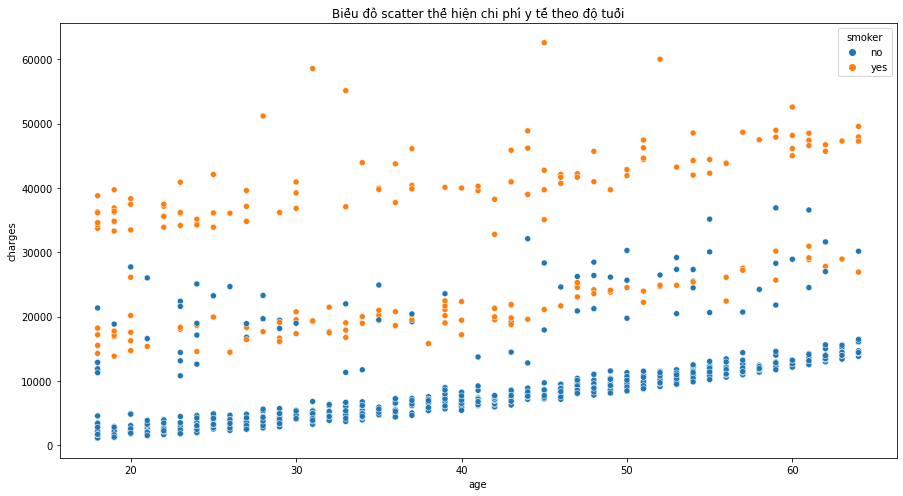

In [14]:
plt.figure(figsize=(15,8))
sns.scatterplot(data = train_df, x='age', y='charges', hue='smoker').set_title('Biểu đồ scatter thể hiện chi phí y tế theo độ tuổi');

Dựa vào biểu đồ trên, mặc dù ta thấy có 3 nhóm đối tượng khác nhau tương ứng với tuổi, tuy nhiên ở cả 3 nhóm này ta đều thấy được rằng, chi phí y tế cá nhân đều tăng khi tuổi tác tăng. Như vậy, độ tuổi là một yếu tố quan trọng quyết định đến chi phí y tế của mỗi người. Ngoài ra, những điểm màu cam là thể hiện cho những người hút thuốc (những người còn lại không hút thuốc), ta có thể thấy chi phí y tế của họ cao hơn rất nhiều so với nhóm đối tượng không hút thuốc (sẽ được phân tích bên dưới).

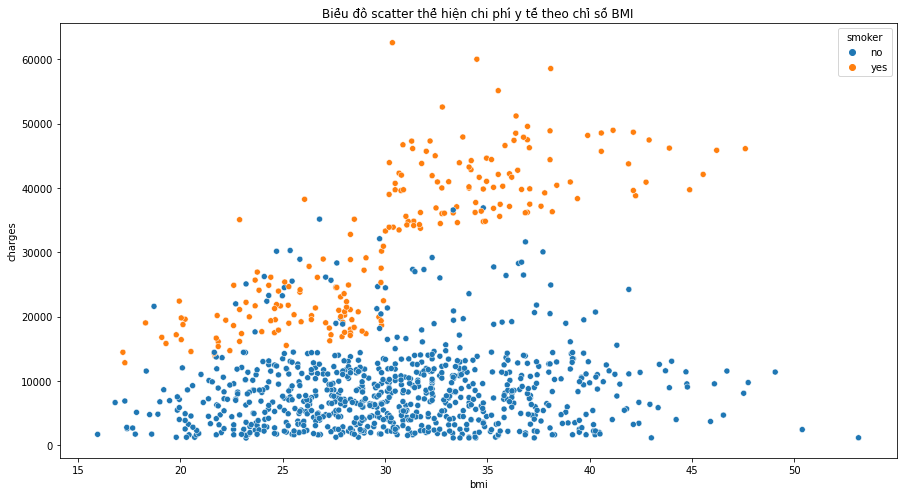

In [15]:
plt.figure(figsize=(15,8))
sns.scatterplot(data = train_df, x='bmi', y='charges', hue='smoker').set_title('Biểu đồ scatter thể hiện chi phí y tế theo chỉ số BMI');

Biểu đồ trên thể hiện mối quan hệ giữa chỉ số “BMI” và chi phí y tế. Biểu đồ này cho ta thấy, có vẻ có 2 nhóm đối tượng riêng biệt ở đây. Một nhóm là có chi phí y tế tăng theo sự tăng của chỉ số BMI, nhóm còn lại có chi phí y tế cố định. Đặc biệt, nhóm người hút thuốc cũng có chi phí y tế cao hơn hẳn nhóm còn lại. Có thể nói, BMI tuy không quyết định nhiều, nhưng nó cũng phần nào ảnh hưởng đến chi phí y tế cá nhân của mọi người.

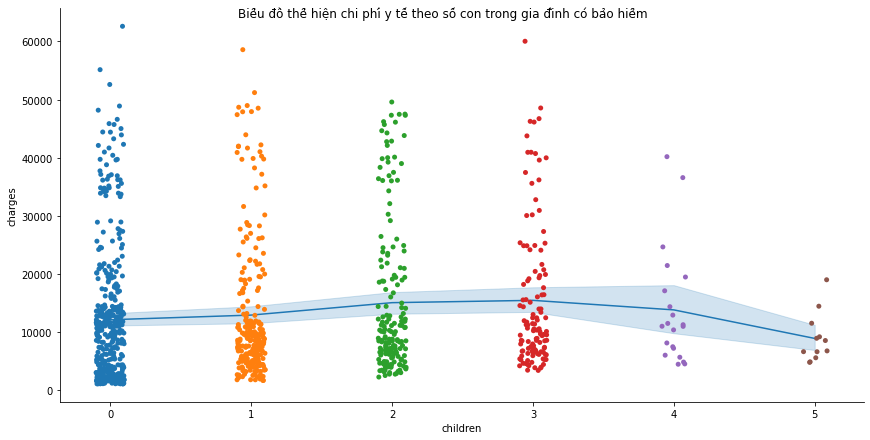

In [16]:
sns.catplot(x="children", y="charges", data=train_df, height=6, aspect=2).fig.suptitle('Biểu đồ thể hiện chi phí y tế theo số con trong gia đình có bảo hiểm');
sns.lineplot(x="children", y="charges", data=train_df);

Ta thấy, chi phí y tế trung bình của các gia đình có 0, 1, 2, 3, 4, 5 con cũng không chênh lệch là mấy (không quá đáng kể). Như vậy, đây cũng là một thuộc tính không quá quan trọng quyết định đến chi phí y tế.

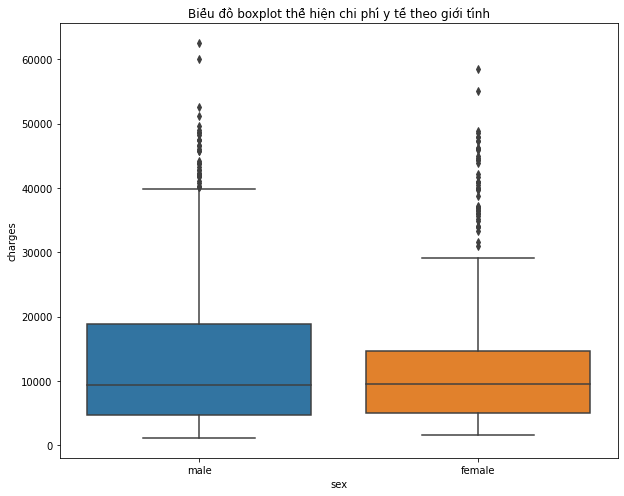

In [17]:
plt.figure(figsize=(10,8))
sns.boxplot(x="sex", y="charges", data=train_df).set_title('Biểu đồ boxplot thể hiện chi phí y tế theo giới tính');

Vậy là giới tính cũng không quyết định nhiều đến chi phí y tế. Ta có thể thấy chi phí y tế là gần như nhau bất kể là nam hay nữ. Điều này cũng hợp với lẽ tự nhiên ở trong cuộc sống thường ngày, bất kể nam hay nữ đều được hưởng một chế độ khám chữa bệnh công bằng.

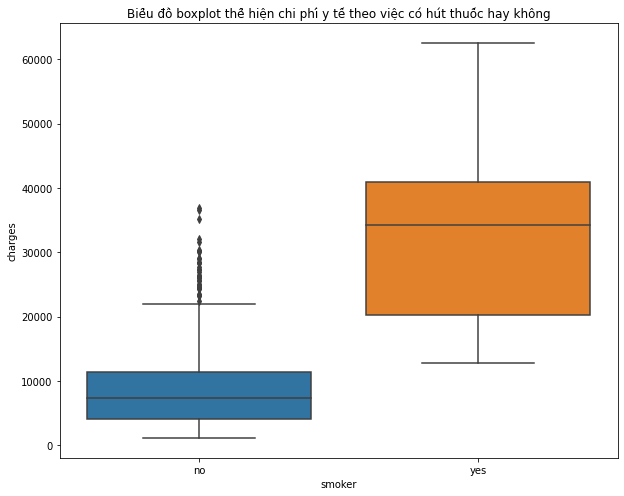

In [18]:
plt.figure(figsize=(10,8))
sns.boxplot(x="smoker", y="charges", data=train_df).set_title('Biểu đồ boxplot thể hiện chi phí y tế theo việc có hút thuốc hay không');

Có sự chênh lệch không hề nhỏ về chi phí y tế cá nhân ở đây. Nhóm người hút thuốc có chi phí khám bệnh cao hơn hẳn so với nhóm còn lại (biểu đồ cho thấy chi phí của nhóm hút thuốc lệch hẳn lên trên so với nhóm không hút thuốc). Đây là một trong những thuộc tính quyết định mạnh đến chi phí y tế của mỗi người. Vì vậy, có thể kết luận rằng hút thuốc làm tăng chi phí khám chữa bệnh của mỗi người, vì người hút thuốc thường hay mắc các bệnh lí dai dẳng liên quan đến khói thuốc và các chất độc hại có trong thuốc.

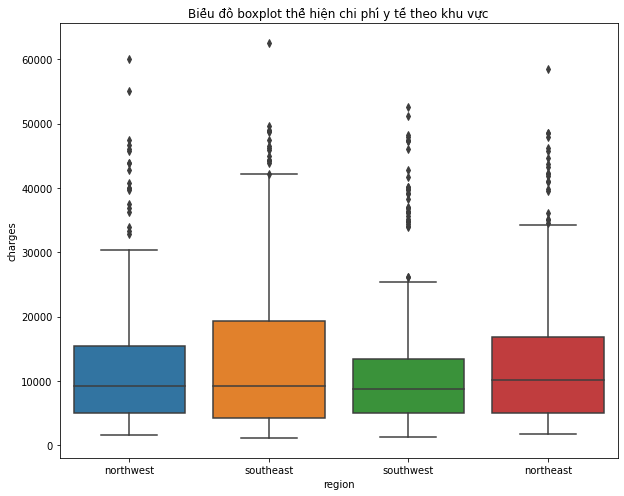

In [19]:
plt.figure(figsize=(10,8))
sns.boxplot(x="region", y="charges", data=train_df).set_title('Biểu đồ boxplot thể hiện chi phí y tế theo khu vực');

Biểu đồ trên chỉ ra rằng chi phí y tế là gần như nhau đối với các khu vực khác nhau. Tuy có vài ngoại lệ, nhưng yếu tố khu vực hầu như không ảnh hưởng đến chi phí y tế cá nhân.

## Tiền xử lý dữ liệu

Tạo pipeline xử lý mising values (tập train không có mising values nhưng phải đề phòng tập test có), chuyển các cột có kiểu categorical không có thứ tự sang dạng số, chuẩn hóa dữ liệu.

Ngoài ra, đối với 2 thuộc tính kiểu số là `Age` và `BMI`, nó đều có các nhóm, cho nên khi xây dựng mô hình ta sẽ dùng phân phối của phân vị thay cho các thuộc tính, điều đó giúp mô hình có thể phân biệt được các nhóm đó hiệu quả hơn.








In [20]:
class MakeQuantileAttr(BaseEstimator, TransformerMixin):
    def __init__(self, custom_quantiles=[0, .05, .1, .2, .25, .3, .4, .5, .6, .7, .75, .8, .9, .95, 1], n_components = 3):
        self.custom_quantiles = custom_quantiles
        self.n_components = n_components
        self.qs_values = {}
        self.PCA_hypers = {}
 
    def fit(self, X_df, y=None):
        transform_cols = ['age', 'bmi']
 
        for c in transform_cols:
            
            qs = X_df[c].quantile(self.custom_quantiles)
            self.qs_values[c] = qs
 
            values = [(X_df[c].iloc[i] > self.qs_values[c]).values * 1 for i in range(len(X_df))]
            
            # use PCA with k = custom features
            self.PCA_hypers[c] = PCA(n_components=self.n_components)
            self.PCA_hypers[c].fit(values)
 
        return self
 
    def transform(self, X_df, y=None):
 
        df = X_df.copy()
        transform_cols = ['age', 'bmi']
 
        for c in transform_cols:
 
            values = np.array([(df[c].iloc[i] > self.qs_values[c]).values * 1 for i in range(len(df))])
 
            reduce_values = self.PCA_hypers[c].transform(values)
 
            col_name_PCA = [f"quantile_p{i}_{c}" for i in range(reduce_values.shape[1])]
 
            df = pd.concat([df, pd.DataFrame(reduce_values, columns=col_name_PCA)], axis=1)
 
        # drop transformed attr
        df = df.drop(transform_cols, axis=1, errors = 'ignore')
 
        return df

Đối với mỗi thuộc tính số, ta lấy các giá trị phân vị 0%, 5%, 10%, 20%, 25%, 30%, 40%, 50%, 60%, 70%, 75%, 80%, 90%, 95% và 100% sau đó dùng PCA để giảm các thuộc tính tương ứng xuống còn số chiều thích hợp.

In [21]:
estimator_makeQuantileAttr = MakeQuantileAttr(custom_quantiles=[0, .05, .1, .2, .25, .3, .4, .5, .6, .7, .75, .8, .9, .95, 1], n_components=3)

In [22]:
data_train_df = estimator_makeQuantileAttr.fit_transform(train_df)
data_train_df.head()

,sex,children,smoker,region,charges,quantile_p0_age,quantile_p1_age,quantile_p2_age,quantile_p0_bmi,quantile_p1_bmi,quantile_p2_bmi
0,male,0,no,northwest,2352.96845,1.433262,0.423642,-0.154729,-1.446130,0.532237,0.044849
1,female,2,no,southeast,4340.44090,0.857633,-0.277229,-0.528665,-0.901486,-0.208234,-0.504307
2,male,1,no,southwest,9391.34600,-0.948370,-0.139691,0.420513,1.582745,0.748759,-0.338973
3,male,1,yes,southeast,42211.13820,-0.630723,-0.517963,0.526948,1.451533,0.532896,-0.045688
4,female,2,no,southwest,8823.27900,-0.630723,-0.517963,0.526948,-0.192462,-0.766899,-0.241721


In [23]:
# important: use transform on test data
data_test_df = estimator_makeQuantileAttr.transform(test_df)

In [24]:
# Tách X và y
y_sr = data_train_df["charges"]
X_df = data_train_df.drop("charges", axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_df, y_sr, random_state=42, test_size=0.2)

y_sr_test = data_test_df["charges"]
X_df_test = data_test_df.drop("charges", axis=1)

In [25]:
# how to use validation-set in cross-validation? 
# chek-me-out: https://stackoverflow.com/a/31949393

val_fold = pd.concat([y_train.transform(lambda x: -1), y_val.transform(lambda x: 0)]).sort_index().values
ps = PredefinedSplit(test_fold=val_fold)
ps

PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1]))

In [26]:
unorder_cate_cols = ['sex', 'smoker', 'region']
order_cate_cols = ['children']
num_cols = list(set(data_train_df.columns.values.tolist()) - set(unorder_cate_cols) -set(order_cate_cols) - set(['bmi', 'age', 'charges']))
#num_cols = ['age', 'bmi']
numeric_transformer = make_pipeline(SimpleImputer(strategy='mean'))

unorder_categorical_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))

order_categorical_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'))

preprocessor = make_column_transformer((numeric_transformer, num_cols),
                                       (unorder_categorical_transformer, unorder_cate_cols),
                                       (order_categorical_transformer, order_cate_cols))

preprocess_pipeline = make_pipeline(preprocessor, StandardScaler())

In [27]:
preprocess_pipeline.fit_transform(X_train).shape

(802, 15)

## Mô hình hóa

### Linear model

#### Linear Regression

In [28]:
linearRegression = make_pipeline(preprocess_pipeline,KMeans(random_state=42), linear_model.LinearRegression())

Tăng hiệu suất mô hình bằng cách sử dụng k-mean để khám phá ra các "cụm" ngầm trong dataset và có thể dùng các cụm này là thuộc tính mới hoặc là tạo dataset thành các partition bằng các cụm này và huấn luyện trên mỗi trường hợp.

In [29]:
param_grid = {'kmeans__n_clusters':[3,5,10,20,50,80,100,120]}
grid_search = GridSearchCV(linearRegression, param_grid,
                           scoring='neg_mean_squared_error',
                           cv=ps,
                           return_train_score=True)
grid_search.fit(X_df, y_sr)
cvres = grid_search.cv_results_
for train_score, test_score, params in zip(cvres["mean_train_score"], cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE train: {np.sqrt(-train_score)}, RMSE validation: {np.sqrt(-test_score)}, {params}')

RMSE train: 7619.148895893541, RMSE validation: 7449.944063912303, {'kmeans__n_clusters': 3}
RMSE train: 7643.144957905699, RMSE validation: 7483.14107079429, {'kmeans__n_clusters': 5}
RMSE train: 7354.926061527949, RMSE validation: 7070.195010817339, {'kmeans__n_clusters': 10}
RMSE train: 6294.4927815106985, RMSE validation: 6138.787098067665, {'kmeans__n_clusters': 20}
RMSE train: 4975.935419182907, RMSE validation: 5229.066210329989, {'kmeans__n_clusters': 50}
RMSE train: 4570.392461931634, RMSE validation: 5099.894446768904, {'kmeans__n_clusters': 80}
RMSE train: 4439.22683311684, RMSE validation: 4817.728175278381, {'kmeans__n_clusters': 100}
RMSE train: 4329.8675211982745, RMSE validation: 4848.669060602187, {'kmeans__n_clusters': 120}


In [30]:
grid_search.best_params_

{'kmeans__n_clusters': 100}

In [31]:
#estimate_model.set_params(kmeans__n_clusters = best_neighbor1)
estimate_model = grid_search.best_estimator_
estimate_model.fit(X_df, y_sr)
print("train + val: ", end = '\t')
y_pred = estimate_model.predict(X_df)
print(f"R2: {estimate_model.score(X_df, y_sr)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr, squared=False)}")

print("test: \t", end = '\t')
y_pred = estimate_model.predict(X_df_test)
print(f"R2: {estimate_model.score(X_df_test, y_sr_test)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr_test, squared=False)}")

train + val: 	R2: 0.8611523180959526	RMSE: 4488.3699544842
test: 		R2: 0.8512638479298109	RMSE: 4737.400922567381


#### Ridge regression 

In [32]:
ridgeRegression = make_pipeline(preprocess_pipeline, KMeans(n_clusters=100, random_state=42),linear_model.Ridge(random_state=42))

In [33]:
param_grid = {'ridge__alpha':[0.01, 0.1, 1, 10], 'kmeans__n_clusters':[3,5,10,20,50,80,100,120]}
grid_search = GridSearchCV(ridgeRegression, param_grid,
                           scoring='neg_mean_squared_error',
                           cv=ps,
                           return_train_score=True)
grid_search.fit(X_df, y_sr)
cvres = grid_search.cv_results_
for train_score, test_score, params in zip(cvres["mean_train_score"], cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE train: {np.sqrt(-train_score)}, RMSE validation: {np.sqrt(-test_score)}, {params}')

RMSE train: 7619.148898095801, RMSE validation: 7449.960413348102, {'kmeans__n_clusters': 3, 'ridge__alpha': 0.01}
RMSE train: 7619.149115950024, RMSE validation: 7450.1076326687225, {'kmeans__n_clusters': 3, 'ridge__alpha': 0.1}
RMSE train: 7619.170733333106, RMSE validation: 7451.5870992266155, {'kmeans__n_clusters': 3, 'ridge__alpha': 1}
RMSE train: 7621.17716628243, RMSE validation: 7467.025934018946, {'kmeans__n_clusters': 3, 'ridge__alpha': 10}
RMSE train: 7643.1449602839975, RMSE validation: 7483.161800205089, {'kmeans__n_clusters': 5, 'ridge__alpha': 0.01}
RMSE train: 7643.145195525065, RMSE validation: 7483.348460539215, {'kmeans__n_clusters': 5, 'ridge__alpha': 0.1}
RMSE train: 7643.168510956988, RMSE validation: 7485.224380627669, {'kmeans__n_clusters': 5, 'ridge__alpha': 1}
RMSE train: 7645.306803944444, RMSE validation: 7504.777400595632, {'kmeans__n_clusters': 5, 'ridge__alpha': 10}
RMSE train: 7354.9261489306855, RMSE validation: 7070.26722401202, {'kmeans__n_clusters': 

In [34]:
grid_search.best_params_

{'kmeans__n_clusters': 100, 'ridge__alpha': 0.01}

In [35]:
estimate_model = best_ridge = grid_search.best_estimator_
estimate_model.fit(X_df, y_sr)

print("train + val: ", end = '\t')
y_pred = estimate_model.predict(X_df)
print(f"R2: {estimate_model.score(X_df, y_sr)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr, squared=False)}")

print("test: \t", end = '\t')
y_pred = estimate_model.predict(X_df_test)
print(f"R2: {estimate_model.score(X_df_test, y_sr_test)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr_test, squared=False)}")

train + val: 	R2: 0.8611521501418646	RMSE: 4488.37266911308
test: 		R2: 0.8513072265061562	RMSE: 4736.710045835482


#### Polynominal regression

In [36]:
polyRegression = make_pipeline(preprocess_pipeline, PolynomialFeatures(), linear_model.LinearRegression())

In [37]:
param_grid = {'polynomialfeatures__degree':[2,3,4]}
grid_search = GridSearchCV(polyRegression, param_grid, cv=ps,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_df, y_sr)
cvres = grid_search.cv_results_
for train_score, test_score, params in zip(cvres["mean_train_score"], cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE train: {np.sqrt(-train_score)}, RMSE validation: {np.sqrt(-test_score)}, {params}')

RMSE train: 4351.583109689339, RMSE validation: 4770.159447625727, {'polynomialfeatures__degree': 2}
RMSE train: 3463.7993518983158, RMSE validation: 6554.210361134963, {'polynomialfeatures__degree': 3}
RMSE train: 2881.780904140355, RMSE validation: 2002641625671171.5, {'polynomialfeatures__degree': 4}


In [38]:
grid_search.best_params_

{'polynomialfeatures__degree': 2}

In [39]:
estimate_model = best_poly = grid_search.best_estimator_
estimate_model.fit(X_df, y_sr)

print("train + val: ", end = '\t')
y_pred = estimate_model.predict(X_df)
print(f"R2: {estimate_model.score(X_df, y_sr)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr, squared=False)}")

print("test: \t", end = '\t')
y_pred = estimate_model.predict(X_df_test)
print(f"R2: {estimate_model.score(X_df_test, y_sr_test)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr_test, squared=False)}")

train + val: 	R2: 0.8194066718097907	RMSE: 5118.823801246272
test: 		R2: 0.824624868705681	RMSE: 5144.176652957929


### Support vector machines

In [40]:
SVM = make_pipeline(preprocess_pipeline, SVR())

In [41]:
param_grid = {'svr__kernel':['linear', 'rbf'], 'svr__C':[10, 100, 10000], 'svr__epsilon':[0.1, 0.15]}

In [42]:
grid_search = GridSearchCV(SVM, param_grid, cv=ps,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_df, y_sr)
cvres = grid_search.cv_results_
for train_score, test_score, params in zip(cvres["mean_train_score"], cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE train: {np.sqrt(-train_score)}, RMSE validation: {np.sqrt(-test_score)}, {params}')

RMSE train: 8265.12097254899, RMSE validation: 8359.153264735816, {'svr__C': 10, 'svr__epsilon': 0.1, 'svr__kernel': 'linear'}
RMSE train: 12523.96717075686, RMSE validation: 12275.333482867267, {'svr__C': 10, 'svr__epsilon': 0.1, 'svr__kernel': 'rbf'}
RMSE train: 8265.132768520516, RMSE validation: 8359.163590438844, {'svr__C': 10, 'svr__epsilon': 0.15, 'svr__kernel': 'linear'}
RMSE train: 12523.969945665214, RMSE validation: 12275.33624520923, {'svr__C': 10, 'svr__epsilon': 0.15, 'svr__kernel': 'rbf'}
RMSE train: 7174.25916719851, RMSE validation: 7346.714701456801, {'svr__C': 100, 'svr__epsilon': 0.1, 'svr__kernel': 'linear'}
RMSE train: 11176.183252795416, RMSE validation: 11022.139979975087, {'svr__C': 100, 'svr__epsilon': 0.1, 'svr__kernel': 'rbf'}
RMSE train: 7174.252815442511, RMSE validation: 7346.706910506146, {'svr__C': 100, 'svr__epsilon': 0.15, 'svr__kernel': 'linear'}
RMSE train: 11176.178022671524, RMSE validation: 11022.13446429159, {'svr__C': 100, 'svr__epsilon': 0.15,

In [43]:
grid_search.best_params_

{'svr__C': 10000, 'svr__epsilon': 0.15, 'svr__kernel': 'rbf'}

In [44]:
estimate_model = grid_search.best_estimator_
estimate_model.fit(X_df, y_sr)

print("train + val: ", end = '\t')
y_pred = estimate_model.predict(X_df)
print(f"R2: {estimate_model.score(X_df, y_sr)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr, squared=False)}")

print("test: \t", end = '\t')
y_pred = estimate_model.predict(X_df_test)
print(f"R2: {estimate_model.score(X_df_test, y_sr_test)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr_test, squared=False)}")

train + val: 	R2: 0.8609191289592684	RMSE: 4492.13739237708
test: 		R2: 0.8599671850489221	RMSE: 4596.706543168329


### MLP

In [45]:
mlp = make_pipeline(preprocess_pipeline, MLPRegressor(max_iter=2000,random_state=42)) 

In [46]:
param_grid = {'mlpregressor__hidden_layer_sizes':[(300, 200, 100), (100, 50)], 'mlpregressor__alpha':[0.01, 0.1]}

In [47]:
grid_search = GridSearchCV(mlp, param_grid, cv=ps,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_df, y_sr)
cvres = grid_search.cv_results_
for train_score, test_score, params in zip(cvres["mean_train_score"], cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE train: {np.sqrt(-train_score)}, RMSE validation: {np.sqrt(-test_score)}, {params}')

RMSE train: 4437.518305710633, RMSE validation: 4656.412869231868, {'mlpregressor__alpha': 0.01, 'mlpregressor__hidden_layer_sizes': (300, 200, 100)}
RMSE train: 4858.27238418243, RMSE validation: 5154.792084021769, {'mlpregressor__alpha': 0.01, 'mlpregressor__hidden_layer_sizes': (100, 50)}
RMSE train: 4437.915299230656, RMSE validation: 4656.058036749385, {'mlpregressor__alpha': 0.1, 'mlpregressor__hidden_layer_sizes': (300, 200, 100)}
RMSE train: 4856.167832276994, RMSE validation: 5152.618316994381, {'mlpregressor__alpha': 0.1, 'mlpregressor__hidden_layer_sizes': (100, 50)}


In [48]:
grid_search.best_params_

{'mlpregressor__alpha': 0.1,
 'mlpregressor__hidden_layer_sizes': (300, 200, 100)}

In [49]:
estimate_model = grid_search.best_estimator_
estimate_model.fit(X_df, y_sr)

print("train + val: ", end = '\t')
y_pred = estimate_model.predict(X_df)
print(f"R2: {estimate_model.score(X_df, y_sr)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr, squared=False)}")

print("test: \t", end = '\t')
y_pred = estimate_model.predict(X_df_test)
print(f"R2: {estimate_model.score(X_df_test, y_sr_test)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr_test, squared=False)}")

train + val: 	R2: 0.8652799057445556	RMSE: 4421.152737788886
test: 		R2: 0.8592509723754826	RMSE: 4608.446722115018


### Decision tree regressor

In [50]:
decisionTree = make_pipeline(preprocess_pipeline, DecisionTreeRegressor(random_state=42))

In [51]:
param_grid = {'decisiontreeregressor__min_samples_leaf':[20,30,40], 'decisiontreeregressor__max_depth':[2,4,6], 
               'decisiontreeregressor__max_leaf_nodes':[10,20,30]}

grid_search = GridSearchCV(decisionTree, param_grid,
                           scoring='neg_mean_squared_error',
                           cv=ps,
                           return_train_score=True)
grid_search.fit(X_df, y_sr)
cvres = grid_search.cv_results_

for train_score, test_score, params in zip(cvres["mean_train_score"], cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE train: {np.sqrt(-train_score)}, RMSE validation: {np.sqrt(-test_score)}, {params}')

RMSE train: 5102.709907373315, RMSE validation: 5035.672363126505, {'decisiontreeregressor__max_depth': 2, 'decisiontreeregressor__max_leaf_nodes': 10, 'decisiontreeregressor__min_samples_leaf': 20}
RMSE train: 5102.709907373315, RMSE validation: 5035.672363126505, {'decisiontreeregressor__max_depth': 2, 'decisiontreeregressor__max_leaf_nodes': 10, 'decisiontreeregressor__min_samples_leaf': 30}
RMSE train: 5102.709907373315, RMSE validation: 5035.672363126505, {'decisiontreeregressor__max_depth': 2, 'decisiontreeregressor__max_leaf_nodes': 10, 'decisiontreeregressor__min_samples_leaf': 40}
RMSE train: 5102.709907373315, RMSE validation: 5035.672363126505, {'decisiontreeregressor__max_depth': 2, 'decisiontreeregressor__max_leaf_nodes': 20, 'decisiontreeregressor__min_samples_leaf': 20}
RMSE train: 5102.709907373315, RMSE validation: 5035.672363126505, {'decisiontreeregressor__max_depth': 2, 'decisiontreeregressor__max_leaf_nodes': 20, 'decisiontreeregressor__min_samples_leaf': 30}
RMSE 

In [52]:
grid_search.best_params_

{'decisiontreeregressor__max_depth': 4,
 'decisiontreeregressor__max_leaf_nodes': 20,
 'decisiontreeregressor__min_samples_leaf': 20}

In [53]:
estimate_model = best_decision = grid_search.best_estimator_
estimate_model.fit(X_df, y_sr)

print("train + val: ", end = '\t')
y_pred = estimate_model.predict(X_df)
print(f"R2: {estimate_model.score(X_df, y_sr)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr, squared=False)}")

print("test: \t", end = '\t')
y_pred = estimate_model.predict(X_df_test)
print(f"R2: {estimate_model.score(X_df_test, y_sr_test)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr_test, squared=False)}")

train + val: 	R2: 0.8612475109997966	RMSE: 4486.831094704703
test: 		R2: 0.860453955816554	RMSE: 4588.710237975776


### Ensemble learning

#### Random Forests

In [54]:
randomForests = make_pipeline(preprocess_pipeline, RandomForestRegressor(random_state=42, n_jobs=-1)) #Train parallel

In [55]:
param_grid = {'randomforestregressor__min_samples_leaf':[20,30,40], 'randomforestregressor__max_depth':[2,4,6], 
               'randomforestregressor__n_estimators':[100,200,300]}

grid_search = GridSearchCV(randomForests, param_grid, cv=ps,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_df, y_sr)
cvres = grid_search.cv_results_
for train_score, test_score, params in zip(cvres["mean_train_score"], cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE train: {np.sqrt(-train_score)}, RMSE validation: {np.sqrt(-test_score)}, {params}')

RMSE train: 5073.18161942923, RMSE validation: 5005.158916336123, {'randomforestregressor__max_depth': 2, 'randomforestregressor__min_samples_leaf': 20, 'randomforestregressor__n_estimators': 100}
RMSE train: 5070.7179637908785, RMSE validation: 5004.659736331931, {'randomforestregressor__max_depth': 2, 'randomforestregressor__min_samples_leaf': 20, 'randomforestregressor__n_estimators': 200}
RMSE train: 5070.806722870546, RMSE validation: 5003.393313163116, {'randomforestregressor__max_depth': 2, 'randomforestregressor__min_samples_leaf': 20, 'randomforestregressor__n_estimators': 300}
RMSE train: 5073.18161942923, RMSE validation: 5005.158916336123, {'randomforestregressor__max_depth': 2, 'randomforestregressor__min_samples_leaf': 30, 'randomforestregressor__n_estimators': 100}
RMSE train: 5070.7179637908785, RMSE validation: 5004.659736331931, {'randomforestregressor__max_depth': 2, 'randomforestregressor__min_samples_leaf': 30, 'randomforestregressor__n_estimators': 200}
RMSE train

In [56]:
grid_search.best_params_

{'randomforestregressor__max_depth': 4,
 'randomforestregressor__min_samples_leaf': 20,
 'randomforestregressor__n_estimators': 100}

In [57]:
estimate_model = best_rf = grid_search.best_estimator_
estimate_model.fit(X_df, y_sr)

print("train + val: ", end = '\t')
y_pred = estimate_model.predict(X_df)
print(f"R2: {estimate_model.score(X_df, y_sr)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr, squared=False)}")

print("test: \t", end = '\t')
y_pred = estimate_model.predict(X_df_test)
print(f"R2: {estimate_model.score(X_df_test, y_sr_test)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr_test, squared=False)}")

train + val: 	R2: 0.863122867475171	RMSE: 4456.4062946331405
test: 		R2: 0.8660683406419382	RMSE: 4495.4533389927965


#### AdaBoost Regressor

In [58]:
adaBoost = make_pipeline(preprocess_pipeline, AdaBoostRegressor(random_state=42)) 

In [59]:
param_grid = {'adaboostregressor__learning_rate':[0.01,0.1,1], 'adaboostregressor__n_estimators':[30,50,100]}

grid_search = GridSearchCV(adaBoost, param_grid, cv=ps,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_df, y_sr)
cvres = grid_search.cv_results_
for train_score, test_score, params in zip(cvres["mean_train_score"], cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE train: {np.sqrt(-train_score)}, RMSE validation: {np.sqrt(-test_score)}, {params}')

RMSE train: 4614.427788026148, RMSE validation: 4698.11480841113, {'adaboostregressor__learning_rate': 0.01, 'adaboostregressor__n_estimators': 30}
RMSE train: 4606.779891380523, RMSE validation: 4607.903477596485, {'adaboostregressor__learning_rate': 0.01, 'adaboostregressor__n_estimators': 50}
RMSE train: 4629.60853749446, RMSE validation: 4636.667534665249, {'adaboostregressor__learning_rate': 0.01, 'adaboostregressor__n_estimators': 100}
RMSE train: 4704.7386509237995, RMSE validation: 4704.8091559525365, {'adaboostregressor__learning_rate': 0.1, 'adaboostregressor__n_estimators': 30}
RMSE train: 4773.208565175445, RMSE validation: 4761.496240751059, {'adaboostregressor__learning_rate': 0.1, 'adaboostregressor__n_estimators': 50}
RMSE train: 4790.506454246954, RMSE validation: 4792.521794086131, {'adaboostregressor__learning_rate': 0.1, 'adaboostregressor__n_estimators': 100}
RMSE train: 4754.358820507916, RMSE validation: 4784.59003297756, {'adaboostregressor__learning_rate': 1, '

In [60]:
grid_search.best_params_

{'adaboostregressor__learning_rate': 0.01,
 'adaboostregressor__n_estimators': 50}

In [61]:
estimate_model = best_ada = grid_search.best_estimator_
estimate_model.fit(X_df, y_sr)

print("train + val: ", end = '\t')
y_pred = estimate_model.predict(X_df)
print(f"R2: {estimate_model.score(X_df, y_sr)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr, squared=False)}")

print("test: \t", end = '\t')
y_pred = estimate_model.predict(X_df_test)
print(f"R2: {estimate_model.score(X_df_test, y_sr_test)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr_test, squared=False)}")

train + val: 	R2: 0.853918271896016	RMSE: 4603.808799284599
test: 		R2: 0.8541293797098657	RMSE: 4691.5438978006105


#### XGBoost regressor

In [62]:
XGBoostregressor = make_pipeline(preprocess_pipeline, XGBRegressor(random_state=42, n_jobs=-1, verbosity = 0)) 

In [63]:
param_grid = {'xgbregressor__learning_rate': [0.01, 0.1, 0.5], 'xgbregressor__max_depth': [2,4,6],
              'xgbregressor__n_estimators': [50,100,150], 'xgbregressor__objective':['reg:linear']}

grid_search = GridSearchCV(XGBoostregressor, param_grid, cv=ps,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_df, y_sr)
cvres = grid_search.cv_results_
for train_score, test_score, params in zip(cvres["mean_train_score"], cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE train: {np.sqrt(-train_score)}, RMSE validation: {np.sqrt(-test_score)}, {params}')

RMSE train: 11639.95360332119, RMSE validation: 11503.219302720801, {'xgbregressor__learning_rate': 0.01, 'xgbregressor__max_depth': 2, 'xgbregressor__n_estimators': 50, 'xgbregressor__objective': 'reg:linear'}
RMSE train: 8125.122874019022, RMSE validation: 7994.605221579584, {'xgbregressor__learning_rate': 0.01, 'xgbregressor__max_depth': 2, 'xgbregressor__n_estimators': 100, 'xgbregressor__objective': 'reg:linear'}
RMSE train: 6298.057861867728, RMSE validation: 6209.958776244649, {'xgbregressor__learning_rate': 0.01, 'xgbregressor__max_depth': 2, 'xgbregressor__n_estimators': 150, 'xgbregressor__objective': 'reg:linear'}
RMSE train: 11543.65633691318, RMSE validation: 11469.132656732592, {'xgbregressor__learning_rate': 0.01, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 50, 'xgbregressor__objective': 'reg:linear'}
RMSE train: 7881.538383190126, RMSE validation: 7898.432108229475, {'xgbregressor__learning_rate': 0.01, 'xgbregressor__max_depth': 4, 'xgbregressor__n_esti

In [64]:
grid_search.best_params_

{'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 4,
 'xgbregressor__n_estimators': 50,
 'xgbregressor__objective': 'reg:linear'}

In [65]:
estimate_model = best_xgboost = grid_search.best_estimator_
estimate_model.fit(X_df, y_sr)

print("train + val: ", end = '\t')
y_pred = estimate_model.predict(X_df)
print(f"R2: {estimate_model.score(X_df, y_sr)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr, squared=False)}")

print("test: \t", end = '\t')
y_pred = estimate_model.predict(X_df_test)
print(f"R2: {estimate_model.score(X_df_test, y_sr_test)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr_test, squared=False)}")

train + val: 	R2: 0.8886557010815589	RMSE: 4019.3268316447607
test: 		R2: 0.8701159454679693	RMSE: 4427.002712647453


#### Gradient Boost Regressor

In [66]:
gradientBoostRegressor = make_pipeline(preprocess_pipeline, GradientBoostingRegressor(random_state=42)) 

In [67]:
param_grid = {
    "gradientboostingregressor__learning_rate": [0.01, 0.1, 0.5],
    "gradientboostingregressor__max_depth":[2,4,6],
    "gradientboostingregressor__n_estimators":[5,10,50]
    }

grid_search = GridSearchCV(gradientBoostRegressor, param_grid, cv=ps,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,n_jobs=-1)
grid_search.fit(X_df, y_sr)
cvres = grid_search.cv_results_
for train_score, test_score, params in zip(cvres["mean_train_score"], cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE train: {np.sqrt(-train_score)}, RMSE validation: {np.sqrt(-test_score)}, {params}')

RMSE train: 11617.53212796373, RMSE validation: 11324.028052859545, {'gradientboostingregressor__learning_rate': 0.01, 'gradientboostingregressor__max_depth': 2, 'gradientboostingregressor__n_estimators': 5}
RMSE train: 11160.262054729239, RMSE validation: 10864.389993705343, {'gradientboostingregressor__learning_rate': 0.01, 'gradientboostingregressor__max_depth': 2, 'gradientboostingregressor__n_estimators': 10}
RMSE train: 8370.60010947184, RMSE validation: 8075.31501734925, {'gradientboostingregressor__learning_rate': 0.01, 'gradientboostingregressor__max_depth': 2, 'gradientboostingregressor__n_estimators': 50}
RMSE train: 11592.091028746601, RMSE validation: 11315.310298615648, {'gradientboostingregressor__learning_rate': 0.01, 'gradientboostingregressor__max_depth': 4, 'gradientboostingregressor__n_estimators': 5}
RMSE train: 11109.98966118745, RMSE validation: 10845.414876610083, {'gradientboostingregressor__learning_rate': 0.01, 'gradientboostingregressor__max_depth': 4, 'grad

In [68]:
grid_search.best_params_

{'gradientboostingregressor__learning_rate': 0.5,
 'gradientboostingregressor__max_depth': 2,
 'gradientboostingregressor__n_estimators': 10}

In [69]:
estimate_model = best_gradientboost = grid_search.best_estimator_
estimate_model.fit(X_df, y_sr)

print("train + val: ", end = '\t')
y_pred = estimate_model.predict(X_df)
print(f"R2: {estimate_model.score(X_df, y_sr)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr, squared=False)}")

print("test: \t", end = '\t')
y_pred = estimate_model.predict(X_df_test)
print(f"R2: {estimate_model.score(X_df_test, y_sr_test)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr_test, squared=False)}")

train + val: 	R2: 0.8637880580273203	RMSE: 4445.564565234638
test: 		R2: 0.865101640372217	RMSE: 4511.64795041816


#### LGBM

In [70]:
LGBMregressor = make_pipeline(preprocess_pipeline, lgb.LGBMRegressor(random_state=42)) 

In [71]:
param_grid ={
    'lgbmregressor__learning_rate': [0.01, 0.05, 0.1],
    'lgbmregressor__max_depth': [2,4,6],
    'lgbmregressor__n_estimators': [30, 50, 100],
}

In [72]:
grid_search = GridSearchCV(LGBMregressor, param_grid, cv=ps,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_df, y_sr)
cvres = grid_search.cv_results_
for train_score, test_score, params in zip(cvres["mean_train_score"], cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE train: {np.sqrt(-train_score)}, RMSE validation: {np.sqrt(-test_score)}, {params}')

RMSE train: 9588.325882621742, RMSE validation: 9288.493594627962, {'lgbmregressor__learning_rate': 0.01, 'lgbmregressor__max_depth': 2, 'lgbmregressor__n_estimators': 30}
RMSE train: 8370.600108204206, RMSE validation: 8075.315014168505, {'lgbmregressor__learning_rate': 0.01, 'lgbmregressor__max_depth': 2, 'lgbmregressor__n_estimators': 50}
RMSE train: 6454.563955392796, RMSE validation: 6196.627938871514, {'lgbmregressor__learning_rate': 0.01, 'lgbmregressor__max_depth': 2, 'lgbmregressor__n_estimators': 100}
RMSE train: 9451.216816612936, RMSE validation: 9219.45630358071, {'lgbmregressor__learning_rate': 0.01, 'lgbmregressor__max_depth': 4, 'lgbmregressor__n_estimators': 30}
RMSE train: 8146.235408566103, RMSE validation: 7953.434644365114, {'lgbmregressor__learning_rate': 0.01, 'lgbmregressor__max_depth': 4, 'lgbmregressor__n_estimators': 50}
RMSE train: 6050.523355713184, RMSE validation: 5975.865250933811, {'lgbmregressor__learning_rate': 0.01, 'lgbmregressor__max_depth': 4, 'lg

In [73]:
grid_search.best_params_

{'lgbmregressor__learning_rate': 0.05,
 'lgbmregressor__max_depth': 4,
 'lgbmregressor__n_estimators': 100}

In [74]:
estimate_model = best_lgbm = grid_search.best_estimator_
estimate_model.fit(X_df, y_sr)

print("train + val: ", end = '\t')
y_pred = estimate_model.predict(X_df)
print(f"R2: {estimate_model.score(X_df, y_sr)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr, squared=False)}")

print("test: \t", end = '\t')
y_pred = estimate_model.predict(X_df_test)
print(f"R2: {estimate_model.score(X_df_test, y_sr_test)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr_test, squared=False)}")

train + val: 	R2: 0.8824374429078318	RMSE: 4130.036041837156
test: 		R2: 0.8700067904727399	RMSE: 4428.86255594171


#### Stacking

Đối với phương pháp stacking, ta sẽ tập hợp các model tốt nhất ở các phần trước để làm đầu vào cho mô hình.

In [75]:
# get last step of these pipes
estimators = [best_rf.steps[-1],
              best_ada.steps[-1],
              best_xgboost.steps[-1],
              best_lgbm.steps[-1]]
final_estimators = GradientBoostingRegressor(n_estimators=50, max_depth=2, learning_rate=0.1, random_state=42)              

In [76]:
stackingRegressor = make_pipeline(preprocess_pipeline, StackingRegressor(estimators=estimators, 
                                                                         final_estimator=final_estimators))

In [77]:
estimate_model = stackingRegressor

estimate_model.fit(X_df, y_sr)

print("train + val: ", end = '\t')
y_pred = estimate_model.predict(X_df)
print(f"R2: {estimate_model.score(X_df, y_sr)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr, squared=False)}")

print("test: \t", end = '\t')
y_pred = estimate_model.predict(X_df_test)
print(f"R2: {estimate_model.score(X_df_test, y_sr_test)}", end = '\t')
print(f"RMSE: {mean_squared_error(y_pred, y_sr_test, squared=False)}")

train + val: 	R2: 0.8750207762827765	RMSE: 4258.319479363611
test: 		R2: 0.8649969484399208	RMSE: 4513.398310973058


## Kết quả

Các linear model tỏ ra yếu thế khi cho độ lỗi trên tập test khá cao có thể do mô hình không đủ tốt để fit vào dữ liệu nên phải dùng thêm thuật toán KMeans để cải thiện dữ liệu như đã trình bày ở trên. Nhưng kỹ thuật này chỉ áp dụng tốt trên linear model.

Nhóm thuật toán Ensemble cho ra kết quả khá tốt vì nó giống như câu "Đoàn kết là sức mạnh". Ý tưởng của nó kết hợp những model "học yếu" lại để tạo ra một model "học mạnh" hơn, không những thế kết quả thu được cũng tốt hơn so với từng model một. Ensemble models cố gắng giảm high variance và high bias nên nó cho ra kết quả tốt trên cả tập train và tập test.

Còn Support vector machines và MLP Regressor cũng cho kết quả khá tốt, có thể sẽ tốt hơn nếu chọn đúng các siêu tham sô phù hợp đặc biệt là hidden_layer_sizes nhưng với kiến thức còn hạn hẹp của nhóm nên chưa thể fine tune mô hình tốt hơn.

Thuật toán XGBoost cho ra độ lỗi thấp nhất trên tập dữ liệu huấn luyện (với RMSE = 4019), tuy nhiên độ lỗi của nó trên tập test lại khá chênh lệch (RMSE = 4426). Tất nhiên về mặt thực tế thì ta vẫn chọn mô hình này để giải dự đoán các bộ dữ liệu trong tương lai bởi vì ta vẫn giả định là chưa hề biết đầy đủ bộ dữ liệu test.

Nhìn lại thuật toán Random Forests, độ lỗi trên bộ train (RMSE = 4456) và bộ test (RMSE = 4495) là khá cân bằng và cũng có độ lỗi khá tốt so với phần còn lại, vì vậy về mặt lý thuyết trong trường hợp bộ dữ liệu này, mô hình này đạt sự cân bằng tốt giữa variance và bias, tốt hơn XGBoost, nhưng nó vẫn không đảm bảo điều đó vẫn sẽ xảy ra trong tương lai. 
